#Duplicate Detection

In [0]:
#import necessary libraries 

import numpy as np
from math import ceil,floor
from PIL import Image, ImageOps
import urllib.request as urllib2
import time
import gc
import pandas as pd
import pprint, pickle

##Hyperparameters

In [0]:
image_max_height = 224 # 224x224 images as model input image
image_max_width = 224
similarity_threshold = 0.79 #Threshold value to detect duplicate/similar image

## Data Preprocessing



---

Our dataset is stored at ** google drive**. So loading dataset from drive

In [3]:
!pip install -U -q PyDrive

!pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id': '1OPWfUURdmg7ywMzv5b7grrd7epradOer'})
# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('dataset.csv')

    100% |████████████████████████████████| 993kB 17.9MB/s 




---

Convert .csv file into **DataFrame** & delete .csv file to release memory

In [1]:
# Import pandas 
import pandas as pd 
  
# reading csv file  
df = pd.read_csv("dataset.csv") 

df.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,productId,title,description,imageUrlStr,mrp,sellingPrice,specialPrice,productUrl,categories,productBrand,...,keySpecsStr,detailedSpecsStr,specificationList,sellerName,sellerAverageRating,sellerNoOfRatings,sellerNoOfReviews,sleeve,neck,idealFor
0,SPWDS7UPDCMEG8WH,Clovia Women's Shapewear,NaN,http://img.fkcdn.com/image/shapewear/8/w/h/sw0...,1199.0,959.0,959.0,http://dl.flipkart.com/dl/clovia-women-s-shape...,Apparels>Women>Lingerie & Sleepwear>Shapewears,Clovia,...,Type: Shapewear;Women's Shapewear;Solid Patter...,Type: Shapewear;Women's Shapewear;Solid Patter...,NaN,Neha Kant,3.6,2123,58,NaN,NaN,NaN
1,SPWDTSM9QHVDHTN6,Clovia Women's Shapewear,NaN,http://img.fkcdn.com/image/shapewear/z/x/w/sw0...,999.0,649.0,616.0,http://dl.flipkart.com/dl/clovia-women-s-shape...,Apparels>Women>Lingerie & Sleepwear>Shapewears,Clovia,...,Type: Thigh Slimmer;Women's Shapewear;Solid Pa...,Type: Thigh Slimmer;Women's Shapewear;Solid Pa...,NaN,Neha Kant,3.6,2123,58,NaN,NaN,NaN
2,SPWDTSMAGMHDNENJ,Clovia Women's Shapewear,NaN,http://img.fkcdn.com/image/shapewear/z/x/w/sw0...,999.0,649.0,616.0,http://dl.flipkart.com/dl/clovia-women-s-shape...,Apparels>Women>Lingerie & Sleepwear>Shapewears,Clovia,...,Type: Thigh Slimmer;Women's Shapewear;Solid Pa...,Type: Thigh Slimmer;Women's Shapewear;Solid Pa...,NaN,Neha Kant,3.6,2123,58,NaN,NaN,NaN
3,SPWDWDT6NQDAHETZ,Triumph Shape 04 PLY Women's Shapewear,NaN,http://img.fkcdn.com/image/shapewear/e/t/z/401...,1899.0,1599.0,1599.0,http://dl.flipkart.com/dl/triumph-shape-04-ply...,Apparels>Women>Lingerie & Sleepwear>Shapewears,Triumph,...,Women's Shapewear;Checkered Pattern;Fabric: 20...,Women's Shapewear;Checkered Pattern;Fabric: 20...,NaN,Satvinder Singh,4.1,245590,2573,NaN,NaN,NaN
4,SPWE4FHG6HUMGBQH,Golden Girl Red Corset Women's Shapewear,NaN,http://img.fkcdn.com/image/shapewear/b/q/h/pan...,1399.0,475.0,475.0,http://dl.flipkart.com/dl/golden-girl-red-cors...,Apparels>Women>Lingerie & Sleepwear>Shapewears,Golden Girl,...,Type: Shapewear;Women's Shapewear;Solid Patter...,Type: Shapewear;Women's Shapewear;Solid Patter...,NaN,AMIT PRAKASH,3.9,379,10,Sleeveless,NaN,NaN


In [0]:
!rm -rf dataset.csv  #delete dataset.csv



---

**Half Dataset & subcategory: Tunics**

As we are running code at google colab , we have 12GB RAM limitation which is unable to run code on entire dataset

So we will process our code on half of original dataset for subcategory:Tunics

In [0]:
#Half Dataset
half_df= df.loc[0:floor(df.shape[0]/2)]
half_df.shape

(2028595, 32)

In [0]:
#Filter   Subcategory: Tunics from dataset [Total 13766 Tunics products from half dataset]

#Tunics:-   Dataframe (All coloums) for subcategory=Tunics 
#my_df:-    Extract imageurl coloums for subcategory=Tunics  
#imageurls:-URLs list

my_df = half_df
my_df = my_df[my_df.categories.str.endswith('Tunics')==True]
Tunics= half_df[half_df.categories.str.endswith('Tunics',na=False)]


my_df = my_df['imageUrlStr'].str.split(pat =";").str.get(2) 
imageurls = my_df.values     #URL list for ~ 400x400 images
print ("shape of imageurls array:" + str (imageurls.shape))
total_url = imageurls.shape[0] 
total_url #Total URL


shape of imageurls array:(13766,)


13766

In [0]:
#Delete unnecessary Dataframe & Release Memory
#Only Need my_df & Tunics for further operation 
del df
del half_df
gc.collect()

31



---


**Download Tunics images from URL list & Convert to Numpy Array**

- Downloaded Image size ~ 400x400 -> resize image to 224x224

- For Invalid URL link, we add simple black image

- Final array shape=(No. of images , W, H, 3)

- In our case shape = (13766, 224, 224, 3)




In [0]:
# Download images(Tunics) & convert to numpy array

images = []
black_image = 0 
for i in range(total_url):
  
  url = imageurls[i]
  if (not i%5000):
    print ("Total Urls:-",i)
  
  try:
    myimage = Image.open(urllib2.urlopen(url))
  except:
    time.sleep(5)      #Try to Handle HTTP Error 503
    try:
      myimage = Image.open(urllib2.urlopen(url))
    except:
      black_image=black_image+1
      myimage = Image.new('RGB', (image_max_width,image_max_height), color = 'black') # WxH black image for invalid image
      
  img    = myimage.resize((image_max_width,image_max_height), resample=Image.BILINEAR ) #Resize image to specific WxH 
  img_array = np.asarray(img)
  images.append(img_array) #Append all images to list
  
  #Total URLs =13766

Total Urls:- 0
Total Urls:- 5000
Total Urls:- 10000


In [0]:
dataset = np.stack(images,axis=0) 
dataset.shape

(13766, 224, 224, 3)

## Use Keras Pre-Trained Models as Feature Extractor



---


Used Pre-Trained DenseNet & ResNet as feature extractor

Due to 12GB RAM limitation again , we are unable to predict output on our dataset in one go.  so we predict output for max 10 data at a time using For loop & then we append all predication outputs 

Here predication output acts as a feature extractor

In [0]:
# Import Keras (latest) 
!pip3 uninstall keras
!pip3 install git+https://github.com/fchollet/keras.git #latest keras repo able us to use ResNet152
import keras

Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.4
  Cloning https://github.com/fchollet/keras.git to /tmp/pip-req-build-th8ziks_
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kb50bmg/wheels/9b/28/23/374425566fc615b7eeb7d748899ed3ce8d72851e4b5d22cc83
Successfully built Keras


Using TensorFlow backend.


###DenseNet

In [0]:
#DenseNet model pre-trained  on imagenet & 224x224 imagesize
DenseNet = keras.applications.densenet.DenseNet169(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

k=0
densenet_features= []
iterations=int ((total_url)/10) #No.of dataset/10

for i in range(iterations):  
  k=i*10
  features = DenseNet.predict(keras.applications.densenet.preprocess_input(dataset[k:k+10]))#10 predictions at a time
  densenet_features.append(features)
  
  
features = DenseNet.predict(keras.applications.densenet.preprocess_input(dataset[k+10:]))#predication output on remaining data(< 10 data)
densenet_features.append(features) #append all predication outputs as list

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#Concatenate all predication outputs in numpy array
import numpy as np 
densenet_features=np.concatenate(densenet_features,axis=0) #shape=(13766, 7, 7, 1664)

###ResNet

In [0]:
##ResNet152 pre-trained model on imagenet & 224x224 imagesize
ResNet = keras.applications.resnet.ResNet152(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
k=0
resnet_features= []
iterations=int ((total_url)/10) #No.of dataset/10

for i in range(iterations):  
  k=i*10
  features = ResNet.predict(keras.applications.resnet.preprocess_input(dataset[k:k+10])) #10 predictions at a time
  resnet_features.append(features)
  
  
features = ResNet.predict(keras.applications.resnet.preprocess_input(dataset[k+10:]))#predication output on remaining data(< 10 data)
resnet_features.append(features)#append all predication output as list

Instructions for updating:
Colocations handled automatically by placer.
234700800/234698864 [==============================] - 3s 0us/step


In [0]:
#Concatenate all predication outputs in numpy array
import numpy as np 
resnet_features=np.concatenate(resnet_features,axis=0) #Shape=(13766, 7, 7, 2048)

In [0]:
#Delete uncessary variable & release memory
del ResNet
del dataset
gc.collect()

0

## Duplicate Detection



---


**Duplicate Detection **

- Use Desnet & Resnet as feature extractor & compute cosine_similarity  between 2 images (among same Unique category)
- if (cosine_similarity > similarity_threshold), then it implies duplicate images
- Consider maxium cosine_similarity value, calculated on Desnet & Resnet architectures
- Different model architectures are sensitive to different characteristics of images. That is reason to use both Denset & Resnet architectures 
(can use more than 2 architecture also)



In [0]:
#Conversion between productID(dataset index) & feature verctor index(resnet/densenet feature index)
def index_to_productid(index):
  product_id=my_df.index[index]
  return product_id
  
def productid_to_index(productid):
  index= np.where(my_df.index==productid)[0]
  return index

In [0]:
#max_similarity logic
def max_similarity(product1,product2):
  
  index1=productid_to_index(product1)
  index2=productid_to_index(product2)
  
  from sklearn.metrics.pairwise import cosine_similarity
  #vgg_sim      = cosine_similarity( vgg_features[index1].reshape(1,-1)      ,  vgg_features[index2].reshape(1,-1) )  
  
  resnet_sim   = cosine_similarity( resnet_features[index1].reshape(1,-1)   ,  resnet_features[index2].reshape(1,-1) ) # calculate cosine_similarity based on resnet  
  densenet_sim = cosine_similarity( densenet_features[index1].reshape(1,-1) ,  densenet_features[index2].reshape(1,-1) ) # calculate cosine_similarity based on densenet
  
  max_sim = max([resnet_sim,densenet_sim]) #Maxium cosine similarity value
  
  return max_sim



---


**Unique Category**:- Classification of product  based on brand & sleeve 

**Intuition of Unique Category**:- Reduce no. of comparisons to find all duplicates (decrease from N*N to ~25N )

**How:**- Instead of comparing all products with each others, we compare products fall under same "Unique Category" 

**Why it Works**:-  Duplicate products have same brand & sleeve value

In [0]:
#Generate Unique Category List 

brands = pd.unique(Tunics.productBrand)    #List of brands
sleeves = pd.unique(Tunics.sleeve)         #List of sleeves types
print("Total Brands" + str(brands.shape))
print("Total Types of sleeve" + str(sleeves.shape))

#Unique category contain list of productIDs having same brand & sleeve type for every brand & sleeve
#Total Unique categories = 1142 in our case
unique_category = []
for brand in brands:
  for sleeve in sleeves:
    items_productID=Tunics[Tunics.productBrand.str.contains(str(brand),na=False) & Tunics.sleeve.str.contains(str(sleeve),na=True)].index
    if(items_productID.size != 0):
      unique_category.append(items_productID)                   

Total Brands(519,)
Total Types of sleeve(10,)




---

**Duplicate Detection**

![alt text](https://i.imgur.com/30YnJI8.jpg)

In [0]:
#Duplicate Detection Logic

print ("Total unique_category by brand & sleeve type:-" + str (len(unique_category)))

duplicate_dict={} 
iteration=0

#Compare items only in same unique_category
for items in unique_category:
  total_items=len(items)
  
  if(not iteration%200):
    print("Total iteration" + str(iteration))
  iteration=iteration+1  
  
  if (total_items >= 1):     #To avoid list containing null/single product
    
    for i in range(total_items) : #Product1
      product1 = items[i]
      matched=[]
      
      for j in range(i+1,total_items) : #Product2
        product2 = items[j]
        max_sim=max_similarity(product1,product2) #calculated max_similarity
        if(max_sim > similarity_threshold):
          matched.append([str(product2),str(max_sim)])  #Duplicate Detected -> append duplicated product 
          
      duplicate_dict[str(product1)] = matched     # List of duplicated products for each productIDs
      
#Total iteration =1142

Total unique_category by brand & sleeve type:-1142
Total iteration0
Total iteration200
Total iteration400
Total iteration600
Total iteration800
Total iteration1000


####Demo:- Duplicates detected

Demo for product id= 731912(image1) & product id = 1382730(image2)

As we see(below) image1 & image2, both products are same having different colour. This algorithm was able detect this duplicates

Read Project_Brief.pdf , For more detail.... 


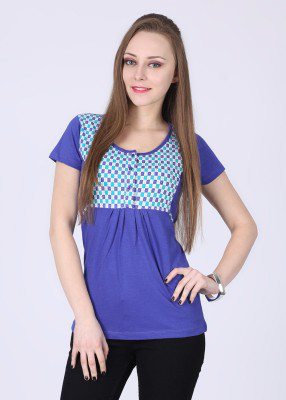

In [0]:
#Image1
url1=Tunics.loc[731912,:][3].split(';')[2]
Image.open(urllib2.urlopen(url1))
  

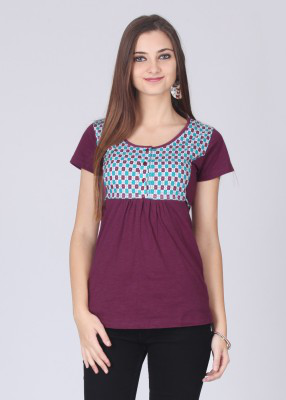

In [0]:
#Image2
url2=Tunics.loc[1382730,:][3].split(';')[2]
Image.open(urllib2.urlopen(url2))